### Task 3

In [40]:
import pandas as pd
import logging
import os
import sys
import mlflow
import pickle
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('../scripts'))

from forecasting.forecast_analysis import load_model, forecast_and_visualize

In [41]:
 datasets = {
        "TSLA": "../data/processed/TSLA_processed.csv",
        "SPY": "../data/processed/SPY_processed.csv",
        "BND": "../data/processed/BND_processed.csv"
    }

In [42]:
steps = 252  # Forecast 1 year

2024-11-19 17:01:03,154 - Loaded ARIMA model for TSLA from C:\Users\USER\Documents\OPLearning\10_Academy\Week_11\models\arima_tsla\model.pkl.


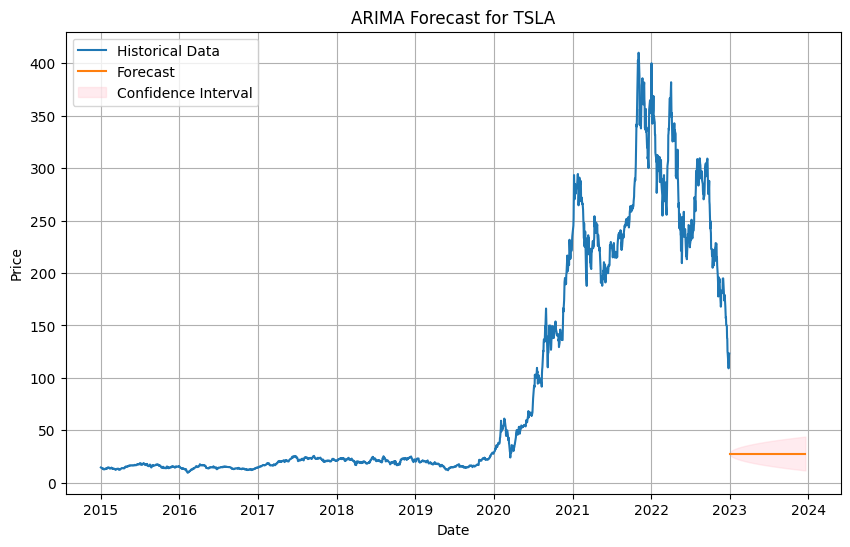

2024-11-19 17:01:05,404 - ARIMA forecast for TSLA completed and visualized.


In [ ]:
import warnings
warnings.filterwarnings("ignore")

for dataset_name, file_path in datasets.items():
    data = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date")
    close_data = data["Close"]

    # Load ARIMA Model
    arima_model = load_model("ARIMA", dataset_name)
    forecast_and_visualize(arima_model, close_data, steps, dataset_name, "ARIMA")

    # Load SARIMA Model
    sarima_model = load_model("SARIMA", dataset_name)
    sarima_forecast = sarima_model.forecast(steps=steps)
    forecast_and_visualize(sarima_model, close_data, steps, dataset_name, "SARIMA")

### Task 4

In [ ]:
forecast_data = {}

In [ ]:
for dataset_name, file_path in datasets.items():
    data = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date")
    close_data = data["Close"]

    sarima_model = load_model("SARIMA", dataset_name)
    sarima_forecast = sarima_model.forecast(steps=steps)
    forecast_data[dataset_name] = sarima_forecast

2024-11-19 16:45:36,688 - Loaded SARIMA model for TSLA from C:\Users\USER\Documents\OPLearning\10_Academy\Week_11\models\sarima_tsla\model.pkl.
2024-11-19 16:45:38,673 - Loaded SARIMA model for SPY from C:\Users\USER\Documents\OPLearning\10_Academy\Week_11\models\sarima_spy\model.pkl.
2024-11-19 16:45:39,643 - Loaded SARIMA model for BND from C:\Users\USER\Documents\OPLearning\10_Academy\Week_11\models\sarima_bnd\model.pkl.


In [ ]:
forecast_df = pd.DataFrame(forecast_data)

In [ ]:
last_date = data.index[-1]
forecast_dates = pd.date_range(start=last_date, periods=steps + 1, freq="B")[1:]  
forecast_df.index = forecast_dates
forecast_df.index.name = "Date"

In [ ]:
forecast_df.columns = ["TSLA", "SPY", "BND"]

In [ ]:
forecast_df.to_csv(r"C:\Users\USER\Documents\OPLearning\10_Academy\Week_11\data\forecasted_returns.csv")

In [ ]:
print(forecast_df.head())

                                TSLA         SPY        BND
Date                                                       
2023-01-02 00:00:00+00:00  27.852222  299.706060  73.770976
2023-01-03 00:00:00+00:00  27.852068  299.636552  73.770434
2023-01-04 00:00:00+00:00  27.808710  299.810798  73.770458
2023-01-05 00:00:00+00:00  27.710982  299.612978  73.770199
2023-01-06 00:00:00+00:00  27.748009  299.654153  73.770340


Compute Portfolio Metrics

In [ ]:
daily_returns = forecast_df.pct_change().dropna()

annual_returns = daily_returns.mean() * 252
logging.info(f"Annual Returns:\n{annual_returns}")

cov_matrix = daily_returns.cov() * 252  
logging.info(f"Covariance Matrix:\n{cov_matrix}")


2024-11-19 16:49:19,042 - Annual Returns:
TSLA    0.073768
SPY     0.080613
BND    -0.000004
dtype: float64
2024-11-19 16:49:19,342 - Covariance Matrix:
              TSLA           SPY           BND
TSLA  5.700039e-04  1.125009e-05 -1.170580e-09
SPY   1.125009e-05  3.521701e-05  8.302135e-09
BND  -1.170580e-09  8.302135e-09  1.110613e-10


Define Portfolio Optimization Functions

In [ ]:
import numpy as np 
from scipy.optimize import minimize

def portfolio_performance(weights, returns, cov_matrix):
    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility

def negative_sharpe_ratio(weights, returns, cov_matrix, risk_free_rate=0.02):
    portfolio_return, portfolio_volatility = portfolio_performance(weights, returns, cov_matrix)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return -sharpe_ratio

def optimize_portfolio(returns, cov_matrix, risk_free_rate=0.02):
    num_assets = len(returns)
    bounds = [(0.0, 1.0) for _ in range(num_assets)]
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    initial_weights = np.ones(num_assets) / num_assets
    
    result = minimize(negative_sharpe_ratio, initial_weights, args=(returns, cov_matrix, risk_free_rate),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x


Perform Optimization and Analyze Portfolio

In [ ]:
optimal_weights = optimize_portfolio(annual_returns, cov_matrix)
logging.info(f"Optimal Weights:\nTSLA: {optimal_weights[0]:.2f}, SPY: {optimal_weights[1]:.2f}, BND: {optimal_weights[2]:.2f}")

portfolio_return, portfolio_volatility = portfolio_performance(optimal_weights, annual_returns, cov_matrix)
sharpe_ratio = (portfolio_return - 0.02) / portfolio_volatility

logging.info(f"Portfolio Return: {portfolio_return:.2%}")
logging.info(f"Portfolio Volatility: {portfolio_volatility:.2%}")
logging.info(f"Sharpe Ratio: {sharpe_ratio:.2f}")

2024-11-19 16:53:32,862 - Optimal Weights:
TSLA: 0.03, SPY: 0.97, BND: 0.00
2024-11-19 16:53:32,863 - Portfolio Return: 8.04%
2024-11-19 16:53:32,863 - Portfolio Volatility: 0.59%
2024-11-19 16:53:32,863 - Sharpe Ratio: 10.32


Risk Metrics (VaR and Drawdowns)

In [ ]:
confidence_level = 0.05
portfolio_daily_returns = np.dot(daily_returns, optimal_weights)
VaR_95 = np.percentile(portfolio_daily_returns, 100 * confidence_level)

logging.info(f"Value at Risk (95%): {VaR_95:.2%}")


2024-11-19 16:54:37,406 - Value at Risk (95%): -0.04%


Visualize Portfolio Performance

Length of forecast index: 252
Length of portfolio_daily_returns: 251


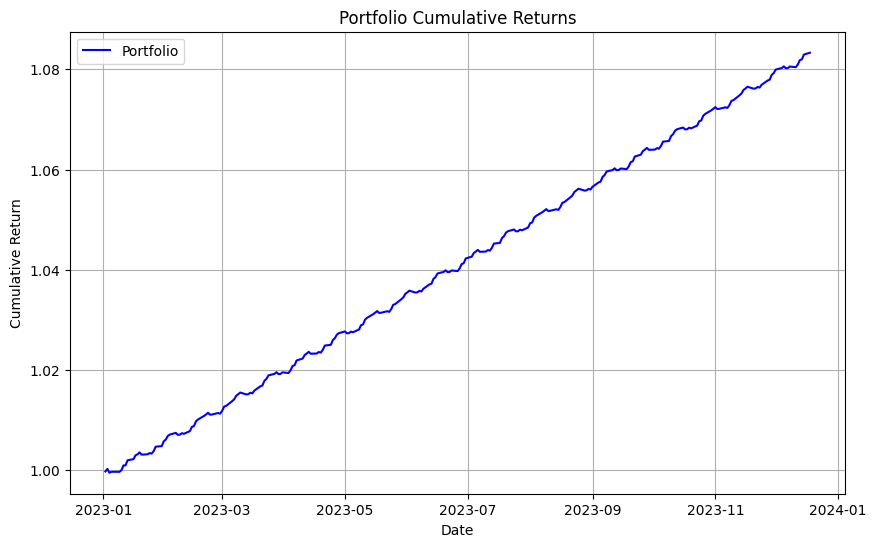

In [ ]:
print(f"Length of forecast index: {len(forecast_df.index)}")
print(f"Length of portfolio_daily_returns: {len(portfolio_daily_returns)}")

aligned_index = forecast_df.index[:len(portfolio_daily_returns)]

portfolio_daily_returns = pd.Series(portfolio_daily_returns, index=aligned_index)

cumulative_returns = (1 + portfolio_daily_returns).cumprod()

plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns, label="Portfolio", color="blue")
plt.title("Portfolio Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid()
plt.show()


Save Results and Final Summary

In [ ]:
results = {
    "Optimal Weights": dict(zip(["TSLA", "SPY", "BND"], optimal_weights)),
    "Portfolio Return": portfolio_return,
    "Portfolio Volatility": portfolio_volatility,
    "Sharpe Ratio": sharpe_ratio,
    "VaR (95%)": VaR_95
}

pd.DataFrame([results]).to_csv("../data/portfolio_optimization_summary.csv", index=False)

logging.info("Portfolio optimization completed and saved.")


2024-11-19 17:00:39,720 - Portfolio optimization completed and saved.
